<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.981 · TFM Àrea 4 · NLP & Text Mining</p>
<p style="margin: 0; text-align:right;">2022 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div class="row" style="padding-top: 50px;">
    <div class="row" style="background: #494949;padding: 10px 20px; color: #FFF">
        <div class="col-md-12">
            <div style="text-align:left;"><b>Estudiant:</b> Albert Cámara Viñals</div>
        </div>
    </div>
</div>

# **T4 - Information Extraction from *synthetic invoice dataset* with *GCN* model**

## **Information extraction**

> Information extraction (IE) is the task of automatically extracting structured information from unstructured and/or semi-structured machine-readable documents and other electronically represented sources. In most of the cases this activity concerns processing images by means computer vision (CV) and processing human language texts by means of natural language processing (NLP).

**Dataset Folder structure**

```
data/
  provider/
      provider-1.csv
      provider-1.pdf
      provider-1.tiff
      provider-1.xml
      ...
  provider/
      provider-1.csv
      provider-1.pdf
      provider-1.tiff
      provider-1.xml
      ...
```

In [1]:
# Load libraries
import cv2
import glob
import pandas as pd
import pickle
import math
import networkx as nx
import numpy as np
import os
import re
import seaborn as sns
import shutil
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from xml.etree import ElementTree as ET
from IPython import display
from bpemb import BPEmb

multibpemb = BPEmb(lang="multi", vs=320000, dim=300)

plt.style.use("ggplot")

%matplotlib inline

## Data Objects

### Define some data models

In [2]:
# Class to store data attributes of Terms
class Term:
    def __init__(self, record):
        self.src = record.src
        self.num_pages = record.num_pages
        self.page_id = record.page_id
        self.page_width = record.page_width
        self.page_height = record.page_height
        self.id = record.id
        self.col = record.col
        self.row = record.row
        self.width = record.width
        self.height = record.height
        self.x1 = record.x1
        self.y1 = record.y1
        self.x2 = record.x2
        self.y2 = record.y2
        self.x3 = record.x3
        self.y3 = record.y3
        self.x4 = record.x4
        self.y4 = record.y4
        self.rdt = None 
        self.rdr = None
        self.rdb = None
        self.rdl = None
        self.content = record.contents
        self.content_masked = record.contents_masked
        self.correctclass = record.correctclass
        self.tag = record.tag
        self.description = record.description
    
    def set_rdt(self, rdt):
        self.rdt = rdt
        
    def get_rdt(self):
        return self.rdt
    
    def set_rdr(self, rdr):
        self.rdr = rdr
        
    def get_rdr(self):
        return self.rdr
    
    def set_rdb(self, rdb):
        self.rdb = rdb
        
    def get_rdb(self):
        return self.rdb
    
    def set_rdl(self, rdl):
        self.rdl = rdl
        
    def get_rdl(self):
        return self.rdl
     
    def show_term(self):
        print(self.src, self.num_pages, self.page_id, self.page_width, self.page_height, self.id, 
              self.col, self.row, self.width, self.height, self.x1, self.x2)
        
    def centroid(self):
        return  (self.x1 + self.width/2, self.y1 + self.height/2)

In [3]:
# Class to store document as a NetworkX
class NetworkData():
    
    def __init__(self, final_connections, G, df):
        self.final_connections = final_connections
        self.G = G
        self.df = df
        
    def get_processed_data(self):
        return self.df
    
    def get_relationships(self):
        return self.final_connections
    
    def get_networkx_graph(self):
        return self.G

## Graph Modeling Algorithm

#### Algorithm 1. Line Formattion

In [4]:
## Algorithm 1. Line Formattion

def extract_lines(df):

    # Sort words based on Top coordinate
    # Sort dataframe by top row and top column (0,0) (left, top)
    df.sort_values(by=['row', 'col'], inplace=True, ascending = [True, True])

    terms = {}
    lines = []  
    line = [Term(df.iloc[0])]

    # Form lines as group of words which obeys the following
    for i in range(1, len(df)):

        wa = Term(df.iloc[i - 1])
        wb = Term(df.iloc[i])

        terms[wa.id] = wa
        terms[wb.id] = wb

        wa_top = wa.y1
        wa_bottom = wa.y4

        wb_top = wb.y1
        wb_bottom = wb.y4

        # Form lines as group of words which obeys the following:
        if wa_top <= wb_bottom and wa_bottom >= wb_bottom:
            #print('Word in same line')
            line.extend([wb])

        else:
            #print('New line')
            if line:
                lines.append(line)
                line = [wb]

        if i == len(df)-1:
            lines.append(line)

    #  Sort words in each line based on Left coordinate
    for line in lines:
        line.sort(key=lambda term: term.x1)
    
    return lines, terms

#### Algorithm 2. Graph Modeling Algorithm

In [5]:
def check_terms_in_vertical_projection(c_term, lines, l_idx):
    #print('Search terms in vertical projection of:', c_term.content)
    projection_terms = []
    for i in range(l_idx + 1, len(lines)):
        for term in lines[i]:
            if c_term.x1 < term.x2 and c_term.x2 > term.x1:
                projection_terms.append(term)
    
    return projection_terms

In [6]:
def check_terms_in_horitzontal_projection(c_term, lines, l_idx, t_idx):
    #print('Search terms in horitzontal projection of:', c_term.content)
    projection_terms = []
    for i in range(l_idx, len(lines)):
        if i == l_idx: 
            for j in range(t_idx +1, len(lines[i])):
                term = lines[i][j]
                if c_term.y1 < term.y4 and c_term.y4 > term.y1:
                    projection_terms.append(term)
        else:
            for term in lines[i]:
                if c_term.y1 < term.y4 and c_term.y4 > term.y1 and c_term.x2 < term.x1:
                    projection_terms.append(term)
                    
    return projection_terms

In [7]:
## Algorithm 2. Graph Modeling Algorithm

def extract_relationships(lines, terms):
    
    relationships =  pd.DataFrame(columns=['n1', 'n2', 'direction'])

    # 1: Read words from each line starting from topmost line going towards bottommost line
    for l_idx, line in enumerate(lines):
        # 2: For each word, perform following:
        for t_idx, term in enumerate(line):

            # 2.1 Check words which are in vertical projection with it:
            terms_in_vertical_projection = check_terms_in_vertical_projection(term, lines, l_idx)

            if terms_in_vertical_projection:
                nnv_term = terms_in_vertical_projection[0]
                least_rdl = 1
                least_rdr = 1

                for pv_term in terms_in_vertical_projection: 
                    rdl = (pv_term.x2 - term.x1)/term.page_width
                    rdr = (pv_term.x1 - term.x2)/term.page_width

                    if abs(rdl) <= least_rdl and abs(rdr) <= least_rdr:
                        least_rdl = abs(rdl)
                        least_rdr = abs(rdr)
                        if pv_term.y1 <= nnv_term.y1:
                            nnv_term = pv_term

                if not ((relationships['n2'] == nnv_term.id) & (relationships['direction'] == 'vertical')).any():
                    rdb = (nnv_term.y1 - term.y3)/term.page_height
                    rdt = -rdb
                    term.set_rdb(rdb)
                    nnv_term.set_rdt(rdt)
                    terms.update({term.id: term, nnv_term.id: nnv_term})
                    relationship = {'n1': term.id,'n2': nnv_term.id, 'direction': 'vertical'}
                    relationships = relationships.append(relationship, ignore_index=True)

                #print('Term in vertical projection:', nnv_term.content)

            #print('') 

            terms_in_horitzontal_projection = check_terms_in_horitzontal_projection(term, lines, l_idx, t_idx)

            if terms_in_horitzontal_projection:
                nnh_term = terms_in_horitzontal_projection[0]
                least_rdt = 1
                least_rdb = 1

                for ph_term in terms_in_horitzontal_projection: 
                    rdt = (ph_term.y4 - term.y1)/term.page_height
                    rdb = (ph_term.y1 - term.y4)/term.page_height

                    if abs(rdt) <= least_rdt and abs(rdb) <= least_rdb:
                        least_rdt = abs(rdt)
                        least_rdb = abs(rdb)
                        if ph_term.x1 <= nnh_term.x1:
                            nnh_term = ph_term

                if not ((relationships['n2'] == nnh_term.id) & (relationships['direction'] == 'horitzontal')).any():
                    rdr = (nnh_term.x1 - term.x2)/term.page_width
                    rdl = -rdr
                    term.set_rdr(rdr)
                    nnh_term.set_rdl(rdl)
                    terms.update({term.id: term, nnh_term.id: nnh_term})
                    relationship = {'n1': term.id ,'n2': nnh_term.id, 'direction': 'horitzontal'}
                    relationships = relationships.append(relationship, ignore_index=True)
                    #print('Term in horitzontal projection:', nnh_term.content)

            #print('\n')
    return relationships

## Functions & Utils

**Define some util functions**

In [8]:
# Function to draw bounding boxes in images
def draw_bouding_boxes(image, data, color):
    image = cv2.imread(image)

    for index, row in data.iterrows():
        cv2.rectangle(image, (row["x1"], row["y1"]), (row["x3"], row["y3"]), color)
           
    return image

# Function to draw bounding boxes and labels in images
def draw_bouding_boxes_and_labels(image, data, color, color_text, thickness, thickness_text):
    image = cv2.imread(image)

    for index, row in data.iterrows():
        cv2.rectangle(image, (row["x1"], row["y1"]), (row["x3"], row["y3"]), color, thickness)
        cv2.putText(image, row['tag'], (row["x1"], row["y1"]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color_text, thickness_text)
    
    return image

# Function to preview image
def show_image(image):   
    cv2.imshow('image', image)
    cv2.namedWindow("PREVIEW", cv2.WINDOW_NORMAL)   # Create window with freedom of dimensions
    image_resized = cv2.resize(image, (595, 842))   # Resize image
    cv2.imshow("PREVIEW", image_resized)            # Show image
    cv2.waitKey(0)                                  # Display the image infinitely until any keypress
        
def get_overlap_x(n1, n2):
    # overlap 
    x1 = max(n1.x1, n2.x1)
    x2 = min(n1.x2, n2.x2)
    
    return math.floor(x1 + (x2 - x1)/2)
    
def get_overlap_y(n1, n2):
    # overlap 
    y1 = max(n1.y1, n2.y1)
    y3 = min(n1.y3, n2.y3)
    
    return math.floor(y1 + (y3-y1)/2)

# Function to draw term relationships in image
def draw_relationships(image, df, relationships, color, thickness):
    
    data = df.copy()
    data.reset_index(inplace=True)
    data = data.rename(columns = {'index': 'id'})
    data = data.set_index('node_id')
    
    for index, relationship in relationships.iterrows():
        n1_id = relationship['n1']
        n2_id = relationship['n2']
        
        n1 = Term(data.loc[n1_id])
        n2 = Term(data.loc[n2_id])
                
        direction = relationship['direction']
                
        if direction == 'vertical':
            start_point = (get_overlap_x(n1, n2), n1.y3)
            end_point = (get_overlap_x(n1, n2), n2.y1)
            cv2.line(image, start_point, end_point, color, thickness)
        else:
            start_point = (n1.x2, get_overlap_y(n1, n2))
            end_point = (n2.x1, get_overlap_y(n1, n2))
            cv2.line(image, start_point, end_point, color, thickness)
    return image

**Define a function to extract features and relationships of a document**

In [9]:
def process_file_to_get_features_and_relationships(filepath):
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    basename = os.path.splitext(filename)[0]
    
    # Read dataframe
    df = pd.read_csv(filepath, sep=';')

    # Delete rows with null content and reset index
    df = df.dropna()
    df = df.reset_index(drop=True)

    # Create attributes
    df['alphabetic'] = df.apply(lambda x: x['contents_masked'].count('A'), axis=1)
    df['numeric'] = df.apply(lambda x: x['contents_masked'].count('N'), axis=1)
    df['symbolic'] = df.apply(lambda x: x['contents_masked'].count('S'), axis=1)
   
    # Extract Lines
    lines, terms = extract_lines(df)

    # Extraxt relationships
    relationships = extract_relationships(lines, terms)
    
    # Prepend the node IDs that occur in each document with some kind of unique identifier for the specific document.
    df['node_id'] = df.apply(lambda x: basename.replace('-', '').lower() + '_' + str(x['id']), axis=1)
    relationships['n1'] = relationships.apply(lambda x: basename.replace('-', '').lower() + '_' + str(x['n1']), axis=1)
    relationships['n2'] = relationships.apply(lambda x: basename.replace('-', '').lower() + '_' + str(x['n2']), axis=1)
    
    # Update document Dataframe with new attributes
    df = df.set_index('id')

    # Assign new attributes to original dataframe
    for k, v in terms.items():
        df.at[k, 'rdt'] = v.get_rdt()
        df.at[k, 'rdr'] = v.get_rdr()
        df.at[k, 'rdb'] = v.get_rdb()
        df.at[k, 'rdl'] = v.get_rdl()
    
    # Create features
    df['f1'] = df.apply(lambda x: x['row']/x['page_height'], axis=1)
    df['f2'] = df.apply(lambda x: x['col']/x['page_width'], axis=1)
    df['f3'] = df.apply(lambda x: x['width']/x['page_width'], axis=1)
    df['f4'] = df.apply(lambda x: x['height']/x['page_height'], axis=1)
    df['f5'] = df.apply(lambda x: x['alphabetic']/len(x['contents']), axis=1)
    df['f6'] = df.apply(lambda x: x['numeric']/len(x['contents']), axis=1)
    df['f7'] = df.apply(lambda x: x['symbolic']/len(x['contents']), axis=1)
    df['f8'] = df.apply(lambda x: x['rdt'] if not np.isnan(x['rdt']) else 0, axis=1)
    df['f9'] = df.apply(lambda x: x['rdr'] if not np.isnan(x['rdr']) else 0, axis=1)
    df['f10'] = df.apply(lambda x: x['rdb'] if not np.isnan(x['rdb']) else 0, axis=1)
    df['f11'] = df.apply(lambda x: x['rdl'] if not np.isnan(x['rdl']) else 0, axis=1)
    df['f12'] = df.apply(lambda x: generate_bpemb_feature(x['contents'], 300), axis=1)
   
    df['feature'] = df.apply(lambda x: np.concatenate((
        np.array( [ x['f1'], x['f2'], x['f3'], x['f4'], x['f5'], x['f6'], x['f7'], x['f8'], x['f9'], x['f10'], x['f11'] ]), 
        x['f12']), axis=None), axis=1)
    
    # Create Graph
    # Add node relations
    G = nx.from_pandas_edgelist(relationships, "n1", "n2", ["direction"])
    
    # Add node features
    for node_id, node_data in G.nodes(data=True):
        node_data["feature"] = df[df['node_id'] == node_id]['feature'].values[0]

    # Store all info in a Object
    networkobject = NetworkData(relationships, G, df)
    
    return networkobject

**Feature Generators**

In [10]:
def generate_bpemb_feature(text, length):
    emb = np.reshape(multibpemb.embed(text), -1)

    if emb.size < length:
        emb = np.pad(emb, (0, length-emb.size), constant_values=0)
    elif emb.size > length:
        emb = emb[0:length]
    else:
        emb = emb
        
    return emb

## Process a single file as example

In [11]:
# Define some working directories
data_dir = './data/examples/'
filename = 'invoice-8.csv'
basename = 'invoice-8'

In [12]:
# Get features, relationships and NetworkX model of a Document
network = process_file_to_get_features_and_relationships(os.path.join(data_dir, filename))

# Get features of Terms of the document
df = network.get_processed_data()
print('Number of Terms:', len(df))

# Get relationships between Terms of the document
relationships = network.get_relationships()
print('Number of relationships:', len(relationships))

# Get NetworkX Graph of the document
G = network.get_networkx_graph()
labels = {d['node_id']: d['contents'] for d in df.to_dict(orient='records')}
edge_colors = ['red' if G[u][v]['direction'] == 'vertical' else 'green'  for u,v in G.edges]

# Show number of Nodes & Edges
print('Number of Nodes:', G.number_of_nodes())
print('Number of Edges:', G.number_of_edges())

Number of Terms: 140
Number of relationships: 202
Number of Nodes: 140
Number of Edges: 202


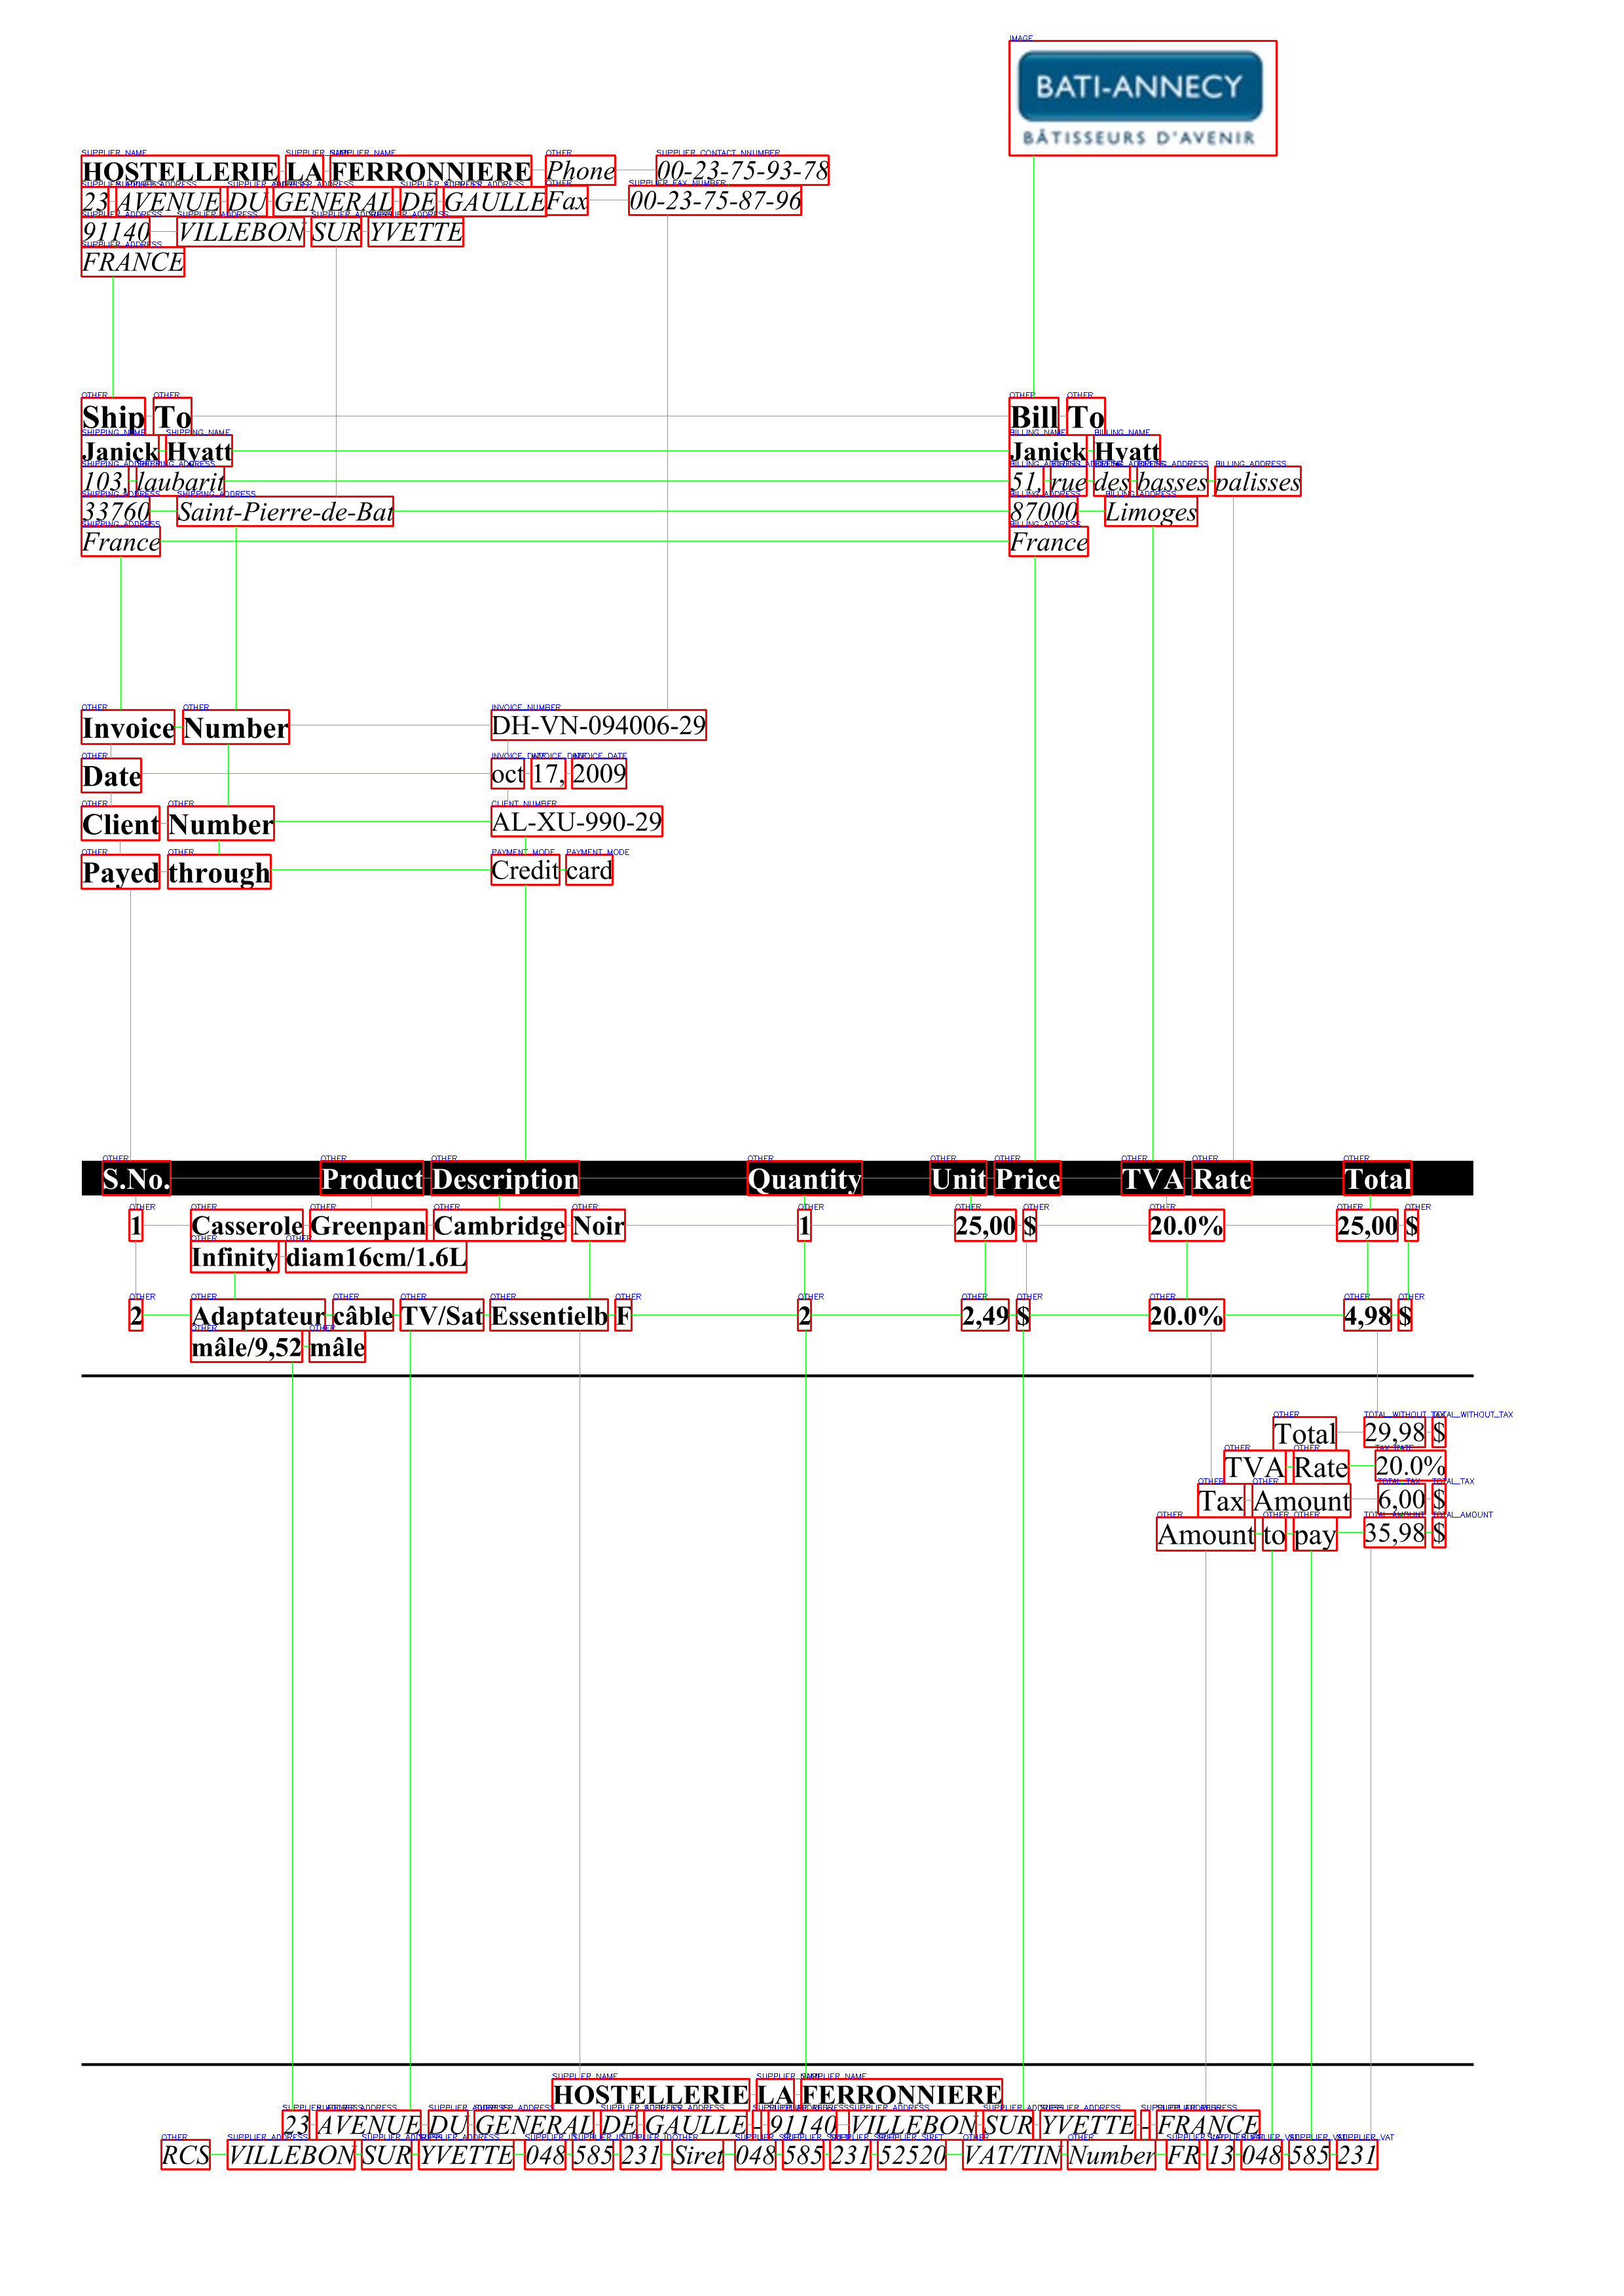

In [13]:
# Draw bounding boxes and labels. Then preview image
image = draw_bouding_boxes_and_labels(os.path.join(data_dir, basename + '.tiff'), df, (0, 0, 255), (255,0, 0), 2, 1)

# Draw relationships
image = draw_relationships(image, df, relationships, (0, 255, 0), 1)

# Write image with bounding boxes, labels and relationships
cv2.imwrite(os.path.join(data_dir, basename + '-relationships.png'), image)

#show_image(image)

display.Image(os.path.join(data_dir, basename + '-relationships.png'))

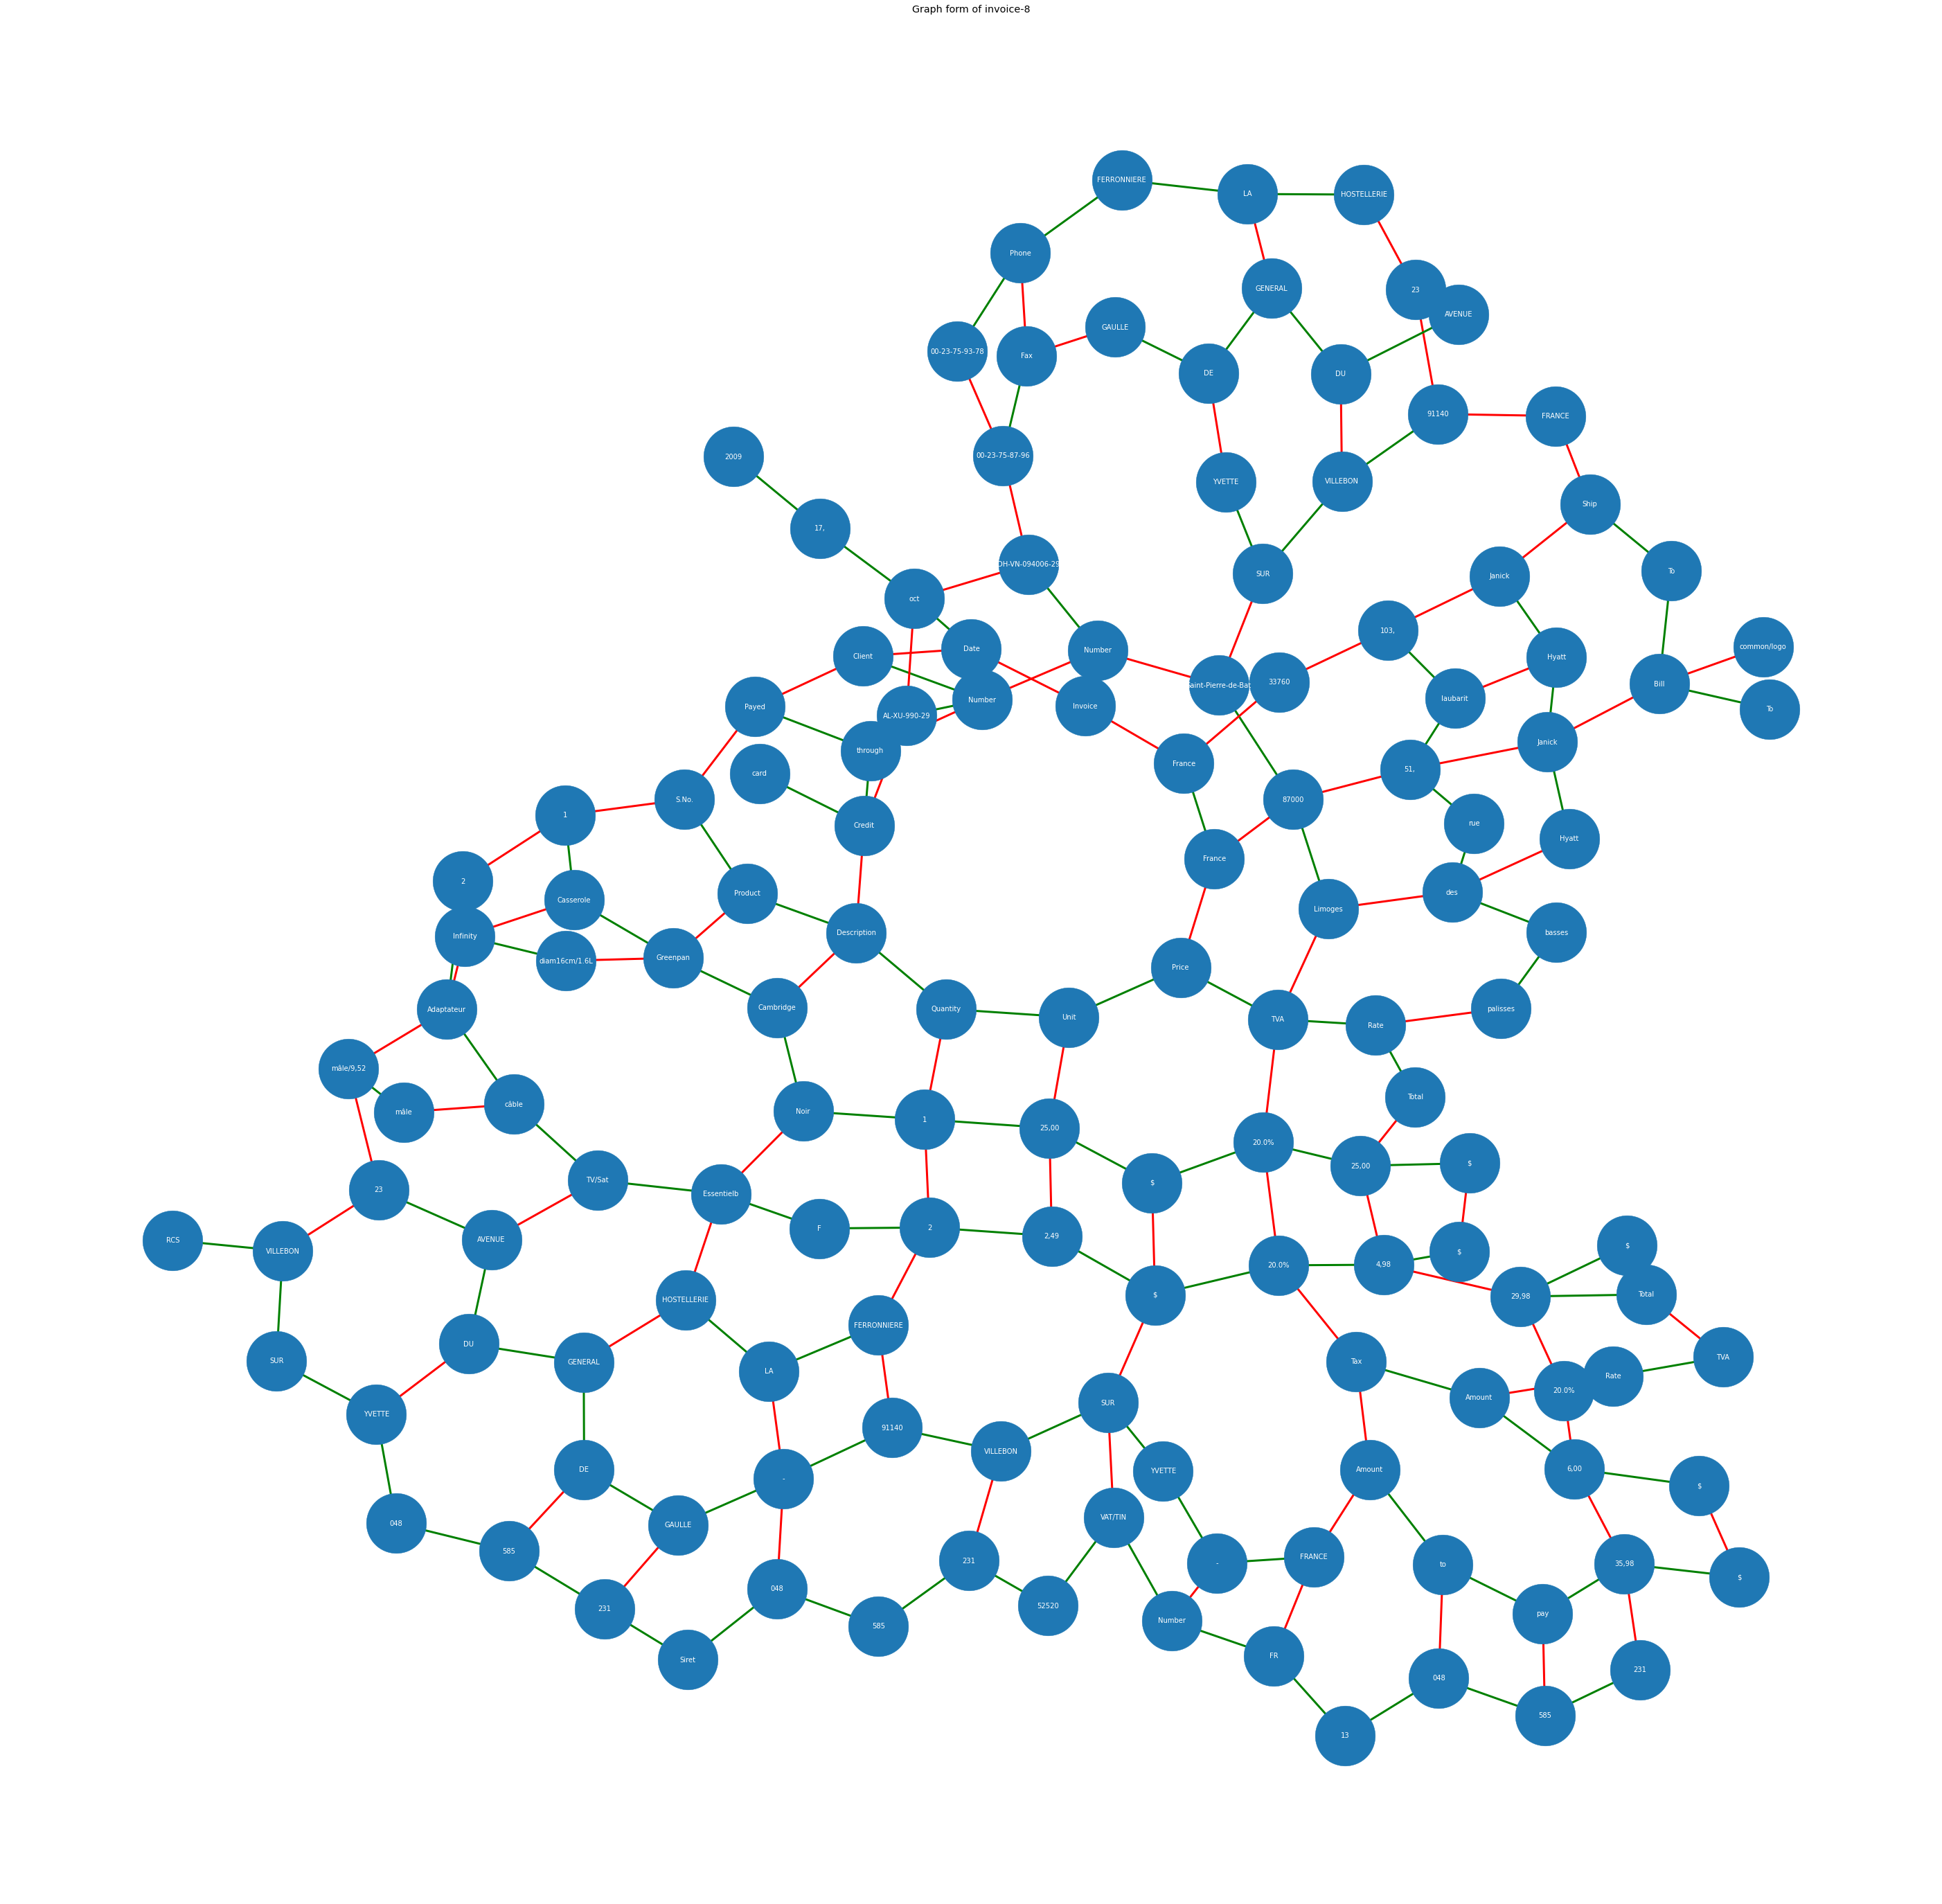

In [14]:
# Preview the graph of the document
layout = nx.kamada_kawai_layout(G)
f = plt.figure(figsize=(50, 50))

ax = plt.gca()
ax.set_title('Graph form of ' + basename)

nx.draw(G, layout, labels=labels, with_labels=True, edge_color=edge_colors, node_size=7500, width=3, alpha=1, font_size=10, font_color="white")
plt.savefig(os.path.join(data_dir, basename + '-graph.jpg'), format="PNG", dpi=f.dpi)

## Data preparation to load into GCN model (process all files)

**Define work directories**

In [15]:
# Define some directories
data_dir = './data/'
dataset_path = './data/synthetic_invoice/'
models_dir = './models/'
transformed_dataset_path = './data/synthetic_invoice/transformed/'

In [16]:
# Explore sample dataframe (document_type, file_name)
samples_list = pd.read_csv(os.path.join(dataset_path, 'samples_list.csv'), dtype=str, sep=';')
samples_list.head()

,type,file,image,pdf,gedi,provider,words
0,invoice,amazon-1.csv,amazon-1.tiff,amazon-1.pdf,amazon-1.xml,amazon,169
1,invoice,amazon-10.csv,amazon-10.tiff,amazon-10.pdf,amazon-10.xml,amazon,183
2,invoice,amazon-100.csv,amazon-100.tiff,amazon-100.pdf,amazon-100.xml,amazon,195
3,invoice,amazon-101.csv,amazon-101.tiff,amazon-101.pdf,amazon-101.xml,amazon,173
4,invoice,amazon-102.csv,amazon-102.tiff,amazon-102.pdf,amazon-102.xml,amazon,205


#### Split dataset into train-val-test sets

In [17]:
# Get list of providers
providers =  samples_list['provider'].values

# Split dataset into train-test sets preserving the representation of each provider
train_samples, test_samples = train_test_split(samples_list, test_size=0.20, random_state=0, stratify=providers)

# Get list of providers
providers =  train_samples['provider'].values

# Split dataset into train-test sets preserving the representation of each provider
train_samples, val_samples = train_test_split(train_samples, test_size=0.50, random_state=0, stratify=providers)

# Show sets size
print('Train size:', train_samples.shape)
print('Validation size:', val_samples.shape)
print('Test size:', test_samples.shape)

Train size: (700, 7)
Validation size: (700, 7)
Test size: (350, 7)


**Process all documents in Train Set**

In [18]:
# Get all documents as a graph representaion or model on Train Set
networks_train = [process_file_to_get_features_and_relationships(os.path.join(transformed_dataset_path, row['provider'], row['file'])) for idx, row in train_samples.iterrows()]

In [19]:
# Save all individual documents graph Networkx on Train Set to file 
file_to_store = open(os.path.join(dataset_path, 'train_documents_networkx_311_features.pickle'), "wb")
pickle.dump(networks_train, file_to_store)
file_to_store.close()

In [20]:
# Union of multiple documents graphs on Train Set
U_train = nx.union_all([network.G for network in networks_train])

print(U_train)

Graph with 136077 nodes and 202702 edges


In [21]:
# Save union of all documents graphs as a Networkx on Train Set to a file
file_to_store = open(os.path.join(dataset_path, 'train_documents_union_networkx_311_feaures.pickle'), "wb")
pickle.dump(U_train, file_to_store)
file_to_store.close()

**Process all documents in Validation Set**

In [22]:
# Make the same processing for Validation Set
networks_val = [process_file_to_get_features_and_relationships(os.path.join(transformed_dataset_path, row['provider'], row['file'])) for idx, row in val_samples.iterrows()]

networks_val_file = open(os.path.join(dataset_path, 'val_documents_networkx_311_features.pickle'), "wb")
pickle.dump(networks_val, networks_val_file)
networks_val_file.close()

# Union of multiple documents graphs 
U_val = nx.union_all([network.G for network in networks_val])

print(U_val)

file_to_store = open(os.path.join(dataset_path, 'val_documents_union_networkx_311_features.pickle'), "wb")
pickle.dump(U_val, file_to_store)
file_to_store.close()

Graph with 134601 nodes and 200308 edges


**Process all documents in Test Set**

In [23]:
# Make the same processing for Test Set
networks_test = [process_file_to_get_features_and_relationships(os.path.join(transformed_dataset_path, row['provider'], row['file'])) for idx, row in test_samples.iterrows()]

file_to_store = open(os.path.join(dataset_path, 'test_documents_networkx_311_features.pickle'), "wb")
pickle.dump(networks_test, file_to_store)
file_to_store.close()

# Union of multiple documents graphs on Test Set
U_test = nx.union_all([network.G for network in networks_test])

print(U_test)

# Save union of all documents graphs as a Networkx on Test Set to a file
file_to_store = open(os.path.join(dataset_path, 'test_documents_union_networkx_311_features.pickle'), "wb")
pickle.dump(U_test, file_to_store)
file_to_store.close()

Graph with 68079 nodes and 101439 edges


In [24]:
# Union of multiple documents graphs on Train, Validation & Set
U = nx.union_all([U_train, U_val, U_test])

print(U)

# Save union of all documents graphs as a Networkx on Train, Validation & Test Set to a file
nx_file = open(os.path.join(dataset_path, 'documents_union_networkx_311_features.pickle'), "wb")
pickle.dump(U, nx_file)
nx_file.close()

Graph with 338757 nodes and 504449 edges


## Modeling

**Prepare data to load into StellarGraph model**

In [25]:
# Load Libraries
import tensorflow as tf
from stellargraph import StellarGraph as sg
from stellargraph import utils
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow import keras
from tensorflow.keras import layers, losses, metrics, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.debugging.set_log_device_placement(True)

tf.__version__

Num GPUs Available:  1


'2.8.0'

In [26]:
# Read union of all documents graphs as a Networkx from file for Train-Test Set
networkx_file = open(os.path.join(dataset_path, 'documents_union_networkx_311_features.pickle'), "rb")
U = pickle.load(networkx_file)
networkx_file.close()
print(U)

Graph with 338757 nodes and 504449 edges


In [27]:
# Load data directly from Networkx into StellarGraph
G_sg = sg.from_networkx(U, node_features="feature")

# Show graph info
print(G_sg.info())

StellarGraph: Undirected multigraph
 Nodes: 338757, Edges: 504449

 Node types:
  default: [338757]
    Features: float32 vector, length 311
    Edge types: default-default->default

 Edge types:
    default-default->default: [504449]
        Weights: all 1 (default)
        Features: none


In [28]:
# Read all individual documents graph Networkx of Train Set
nx_train_file = open(os.path.join(dataset_path, 'train_documents_networkx_311_features.pickle'), "rb")
nx_train = pickle.load(nx_train_file)
nx_train_file.close()

print('Number of document networks on Train Set:', len(nx_train))

Number of document networks on Train Set: 700


In [29]:
# Get labels for each node on Train Set

# Get labels of NetworkData
labels_train = [network.df[['node_id', 'tag']] for network in nx_train]

# Create a Dataframe of Nodes, Labels
tagged_data_train = pd.concat(labels_train, sort=False)
tagged_data_train.rename(columns = {'tag': 'node_target'}, inplace = True)

train = tagged_data_train

# Show number of Labels
print('Number of labels on Train Set:', len(tagged_data_train))

Number of labels on Train Set: 136077


In [30]:
# Compute frequency on each one of classes for class attribute 'node_target'
tagged_data_train["node_target"].value_counts()

OTHER                              73791
PRODUCT_DESCRIPTION                11654
SUPPLIER_ADDRESS                    7134
BILLING_ADDRESS                     4634
SHIPPING_ADDRESS                    4520
INVOICE_DATE                        2914
SUPPLIER_VAT                        2822
SUPPLIER_NAME                       2683
PRODUCT_TOTAL_PRICE_WITHOUT_TAX     2504
SUPPLIER_CONTACT_NUMBER             2388
UNIT_PRICE                          2305
SUPPLIER_FAX_NUMBER                 2039
QUANTITY                            1787
SHIPPING_NAME                       1656
BILLING_NAME                        1655
TOTAL_AMOUNT                        1599
TAX_RATE                            1418
TOTAL_TAX                           1249
SNO                                 1220
SUPPLIER_SIRET                       982
TOTAL_WITHOUT_TAX                    979
INVOICE_NUMBER                       937
ORDER_NUMBER                         700
SUPPLIER_ID                          602
PRODUCT_TOTAL   

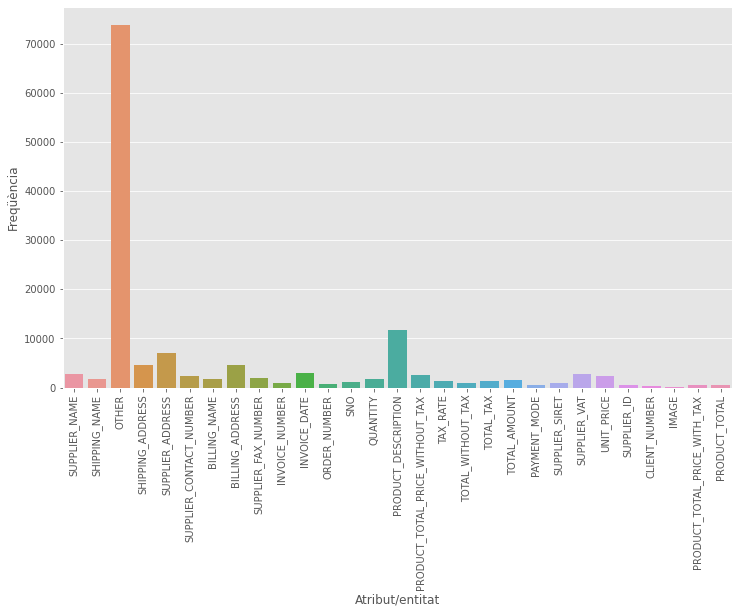

In [31]:
# Create barchart for class attribute 'TAG'
plt.figure(figsize=(12, 7))
g1 = sns.countplot(x="node_target", data=tagged_data_train)
plt.xlabel('Atribut/entitat')
plt.ylabel('Freqüència')
plt.xticks(rotation='vertical')

obs = len(tagged_data_train);

# Add tags to graph
#for p, label in zip(g1.patches, tagged_data_train["node_target"].value_counts().index):
#    g1.annotate(' (' + str(round(p.get_height()/obs*100, 2)) + '%)' , (p.get_x() + 0.05, p.get_height() + 1500))

In [32]:
# Read all individual documents graph Networkx of Validation Set
nx_val_file = open(os.path.join(dataset_path, 'val_documents_networkx_311_features.pickle'), "rb")
nx_val = pickle.load(nx_val_file)
nx_val_file.close()
print('Number of document networks on Validation Set:', len(nx_val))

# Get labels for each node on Validation Set

# Get labels of NetworkData
labels_val = [network.df[['node_id', 'tag']] for network in nx_val]
tagged_data_val = pd.concat(labels_val, sort=False)
tagged_data_val.rename(columns = {'tag':'node_target'}, inplace = True)

val = tagged_data_val

print('Number of labels on Validation Set:', len(tagged_data_val))

Number of document networks on Validation Set: 700
Number of labels on Validation Set: 134601


In [33]:
# Read all individual documents graph Networkx of Test Set
nx_test_file = open(os.path.join(dataset_path, 'test_documents_networkx_311_features.pickle'), "rb")
nx_test = pickle.load(nx_test_file)
nx_test_file.close()
print('Number of document networks on Test Set:', len(nx_test))

# Get labels for each node on Test Set

# Get labels of NetworkData
labels_test = [network.df[['node_id', 'tag']] for network in nx_test]
tagged_data_test = pd.concat(labels_test, sort=False)
tagged_data_test.rename(columns = {'tag':'node_target'}, inplace = True)

test = tagged_data_test

print('Number of labels on Test Set:', len(tagged_data_test))

Number of document networks on Test Set: 350
Number of labels on Test Set: 68079


In [34]:
# Encoding the targets
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train.node_target)
val_targets = target_encoding.fit_transform(val.node_target)
test_targets = target_encoding.fit_transform(test.node_target)

# Examine size
print('Train:', train.shape, train_targets.shape)
print('Validation:', val.shape, val_targets.shape)
print('Test:', test.shape, test_targets.shape)

Train: (136077, 2) (136077, 29)
Validation: (134601, 2) (134601, 29)
Test: (68079, 2) (68079, 29)


In [35]:
# Create a generator function to generate batches of nodes given the Stellar Network Graph.
generator = FullBatchNodeGenerator(G_sg, method="gcn")

Using GCN (local pooling) filters...


In [36]:
# Call the flow function and pass the target label and the nodes to get an object that can be used as a Keras data generator.
train_gen = generator.flow(train.node_id, train_targets)
val_gen = generator.flow(val.node_id, val_targets)

**Build model**

In [37]:
# Model Formation
# Four layers of GCN

def build_gcn_model(learning_rate):  
    # create convolutional layers
    gcn = GCN(layer_sizes=[16, 32, 64, 128], activations=["relu", "relu", "relu", "relu"], generator=generator, kernel_regularizer = regularizers.l2(0.0005))

    # expose in and out to create keras model
    x_inp, x_out = gcn.in_out_tensors()

    # usual output layer
    predictions = layers.Dense(units=train_targets.shape[1], activation = "softmax")(x_out)

    # define model
    model = Model(inputs=x_inp, outputs=predictions)

    # compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=losses.categorical_crossentropy, metrics=['accuracy'])
    
    return model
    
# Build the GCN model
gcn_model = build_gcn_model(0.01)

In [38]:
# Validate model blocks
print(gcn_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 338757, 311)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout (Dropout)              (1, 338757, 311)     0           ['input_1[0][0]']                
                                                                                              

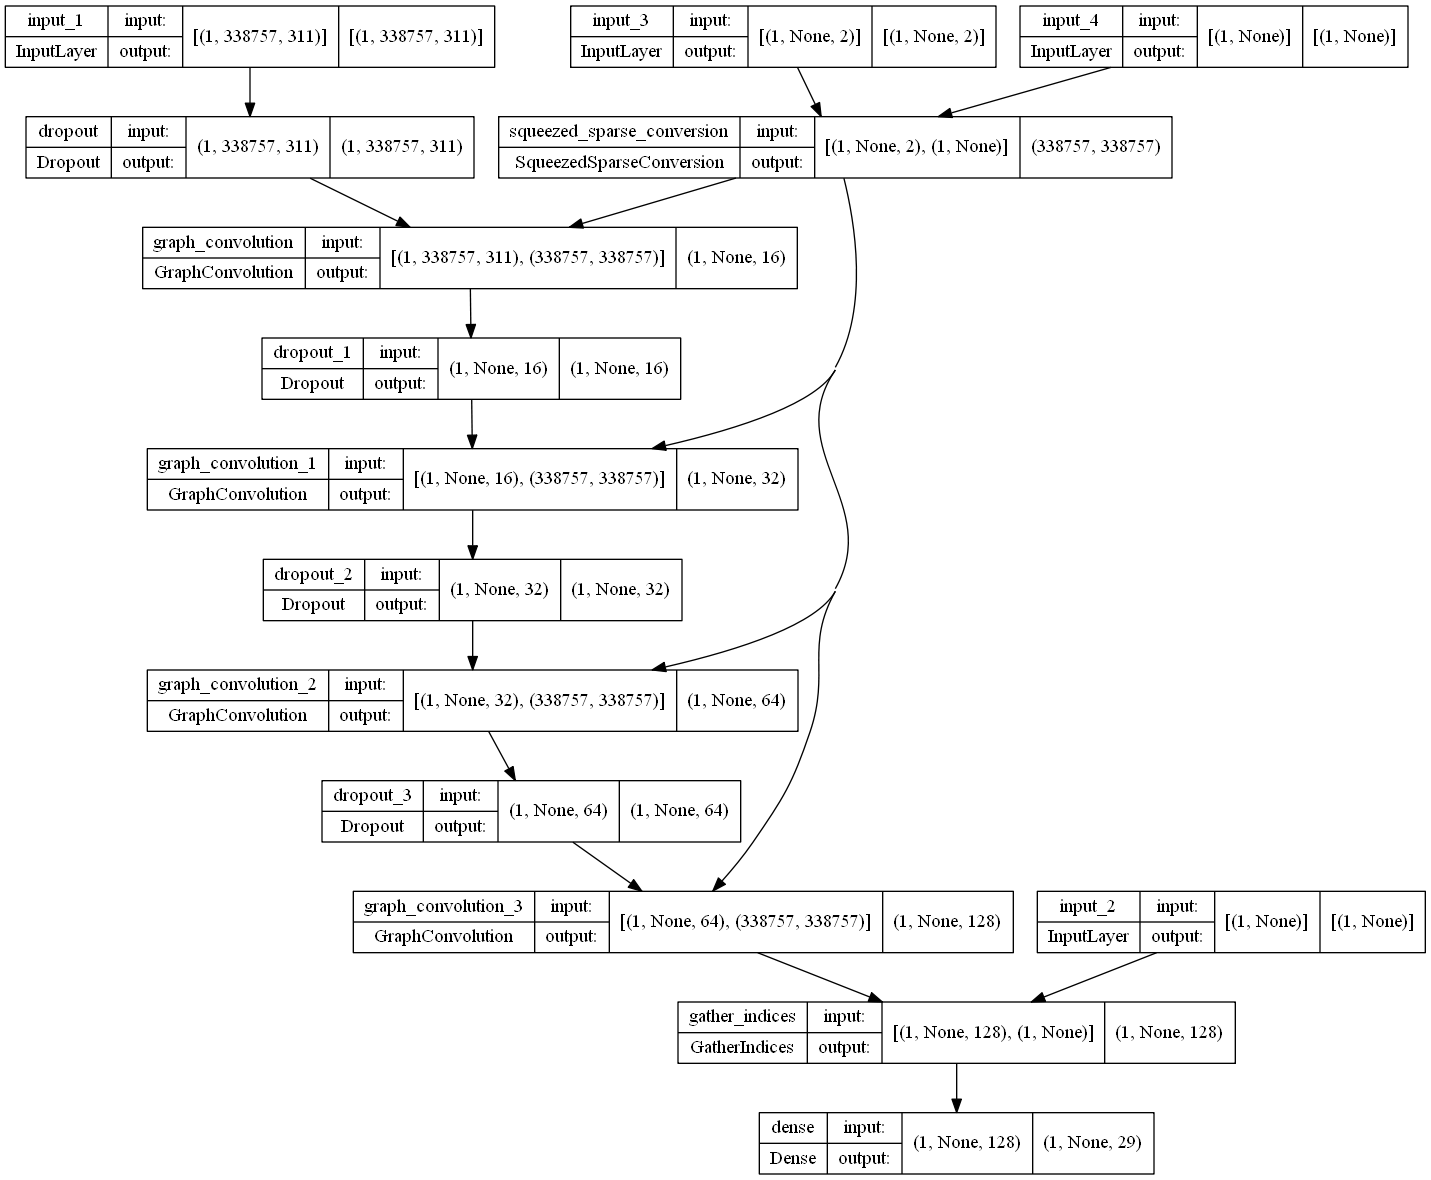

In [39]:
from keras.utils.vis_utils import plot_model

# Preview model
plot_model(gcn_model, to_file=os.path.join(models_dir, 'gcn_model_311_features_plot.png'), show_shapes=True, show_layer_names=True)

## Training and Model performance plots

In [40]:
# Fit the model and check the result
epochs = 2000
patience = 50

gcn_early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=1)

gcn_history = gcn_model.fit(train_gen, epochs=epochs, validation_data=val_gen, shuffle=False, verbose=1, callbacks=[gcn_early_stopping])

Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 3.4809 - accuracy: 0.0175 - val_loss: 3.3336 - val_accuracy: 0.5456
Epoch 2/2000
1/1 [==============================] - 0s 396ms/step - loss: 3.3341 - accuracy: 0.5423 - val_loss: 3.0098 - val_accuracy: 0.5456
Epoch 3/2000
1/1 [==============================] - 0s 379ms/step - loss: 3.0119 - accuracy: 0.5423 - val_loss: 2.4575 - val_accuracy: 0.5456
Epoch 4/2000
1/1 [==============================] - 0s 385ms/step - loss: 2.4632 - accuracy: 0.5423 - val_loss: 2.2948 - val_accuracy: 0.5456
Epoch 5/2000
1/1 [==============================] - 0s 384ms/step - loss: 2.3102 - accuracy: 0.5423 - val_loss: 2.3478 - val_accuracy: 0.5456
Epoch 6/2000
1/1 [==============================] - 0s 382ms/step - loss: 2.3621 - accuracy: 0.5423 - val_loss: 2.1102 - val_accuracy: 0.5456
Epoch 7/2000
1/1 [==============================] - 0s 382ms/step - loss: 2.1194 - accuracy: 0.5423 - val_loss: 2.0614 - val_accuracy: 0.5456
Epoch 8/2

1/1 [==============================] - 0s 397ms/step - loss: 0.7731 - accuracy: 0.7620 - val_loss: 0.7843 - val_accuracy: 0.7574
Epoch 116/2000
1/1 [==============================] - 0s 406ms/step - loss: 0.7730 - accuracy: 0.7617 - val_loss: 0.7803 - val_accuracy: 0.7586
Epoch 117/2000
1/1 [==============================] - 0s 404ms/step - loss: 0.7682 - accuracy: 0.7629 - val_loss: 0.7780 - val_accuracy: 0.7596
Epoch 118/2000
1/1 [==============================] - 0s 406ms/step - loss: 0.7677 - accuracy: 0.7640 - val_loss: 0.7738 - val_accuracy: 0.7598
Epoch 119/2000
1/1 [==============================] - 0s 402ms/step - loss: 0.7619 - accuracy: 0.7648 - val_loss: 0.7848 - val_accuracy: 0.7582
Epoch 120/2000
1/1 [==============================] - 0s 413ms/step - loss: 0.7736 - accuracy: 0.7617 - val_loss: 0.8151 - val_accuracy: 0.7435
Epoch 121/2000
1/1 [==============================] - 0s 402ms/step - loss: 0.8031 - accuracy: 0.7476 - val_loss: 0.8664 - val_accuracy: 0.7283
Epoch 1

Epoch 172/2000
1/1 [==============================] - 0s 403ms/step - loss: 0.6662 - accuracy: 0.7945 - val_loss: 0.6725 - val_accuracy: 0.7931
Epoch 173/2000
1/1 [==============================] - 0s 410ms/step - loss: 0.6592 - accuracy: 0.7984 - val_loss: 0.6888 - val_accuracy: 0.7855
Epoch 174/2000
1/1 [==============================] - 0s 430ms/step - loss: 0.6740 - accuracy: 0.7904 - val_loss: 0.6694 - val_accuracy: 0.7946
Epoch 175/2000
1/1 [==============================] - 0s 399ms/step - loss: 0.6552 - accuracy: 0.8002 - val_loss: 0.6707 - val_accuracy: 0.7933
Epoch 176/2000
1/1 [==============================] - 0s 411ms/step - loss: 0.6574 - accuracy: 0.7992 - val_loss: 0.6799 - val_accuracy: 0.7886
Epoch 177/2000
1/1 [==============================] - 0s 406ms/step - loss: 0.6640 - accuracy: 0.7928 - val_loss: 0.6606 - val_accuracy: 0.7971
Epoch 178/2000
1/1 [==============================] - 0s 397ms/step - loss: 0.6462 - accuracy: 0.8033 - val_loss: 0.6662 - val_accuracy:

Epoch 229/2000
1/1 [==============================] - 0s 401ms/step - loss: 0.5973 - accuracy: 0.8187 - val_loss: 0.6348 - val_accuracy: 0.8070
Epoch 230/2000
1/1 [==============================] - 0s 398ms/step - loss: 0.6146 - accuracy: 0.8133 - val_loss: 0.6281 - val_accuracy: 0.8069
Epoch 231/2000
1/1 [==============================] - 0s 404ms/step - loss: 0.6112 - accuracy: 0.8130 - val_loss: 0.6125 - val_accuracy: 0.8131
Epoch 232/2000
1/1 [==============================] - 0s 396ms/step - loss: 0.5938 - accuracy: 0.8199 - val_loss: 0.6262 - val_accuracy: 0.8104
Epoch 233/2000
1/1 [==============================] - 0s 398ms/step - loss: 0.6081 - accuracy: 0.8164 - val_loss: 0.6239 - val_accuracy: 0.8089
Epoch 234/2000
1/1 [==============================] - 0s 402ms/step - loss: 0.6052 - accuracy: 0.8154 - val_loss: 0.6054 - val_accuracy: 0.8172
Epoch 235/2000
1/1 [==============================] - 0s 400ms/step - loss: 0.5876 - accuracy: 0.8231 - val_loss: 0.6230 - val_accuracy:

Epoch 286/2000
1/1 [==============================] - 0s 390ms/step - loss: 0.5613 - accuracy: 0.8333 - val_loss: 0.5771 - val_accuracy: 0.8293
Epoch 287/2000
1/1 [==============================] - 0s 395ms/step - loss: 0.5542 - accuracy: 0.8365 - val_loss: 0.5713 - val_accuracy: 0.8282
Epoch 288/2000
1/1 [==============================] - 0s 397ms/step - loss: 0.5485 - accuracy: 0.8364 - val_loss: 0.5762 - val_accuracy: 0.8269
Epoch 289/2000
1/1 [==============================] - 0s 387ms/step - loss: 0.5558 - accuracy: 0.8334 - val_loss: 0.5928 - val_accuracy: 0.8223
Epoch 290/2000
1/1 [==============================] - 0s 384ms/step - loss: 0.5673 - accuracy: 0.8305 - val_loss: 0.5913 - val_accuracy: 0.8196
Epoch 291/2000
1/1 [==============================] - 0s 391ms/step - loss: 0.5715 - accuracy: 0.8263 - val_loss: 0.6197 - val_accuracy: 0.8120
Epoch 292/2000
1/1 [==============================] - 0s 394ms/step - loss: 0.5946 - accuracy: 0.8192 - val_loss: 0.6773 - val_accuracy:

Epoch 343/2000
1/1 [==============================] - 0s 386ms/step - loss: 0.5262 - accuracy: 0.8445 - val_loss: 0.5482 - val_accuracy: 0.8402
Epoch 344/2000
1/1 [==============================] - 0s 386ms/step - loss: 0.5217 - accuracy: 0.8489 - val_loss: 0.5500 - val_accuracy: 0.8387
Epoch 345/2000
1/1 [==============================] - 0s 390ms/step - loss: 0.5256 - accuracy: 0.8475 - val_loss: 0.5611 - val_accuracy: 0.8328
Epoch 346/2000
1/1 [==============================] - 0s 385ms/step - loss: 0.5328 - accuracy: 0.8405 - val_loss: 0.5658 - val_accuracy: 0.8317
Epoch 347/2000
1/1 [==============================] - 0s 402ms/step - loss: 0.5439 - accuracy: 0.8392 - val_loss: 0.5979 - val_accuracy: 0.8205
Epoch 348/2000
1/1 [==============================] - 0s 417ms/step - loss: 0.5665 - accuracy: 0.8275 - val_loss: 0.6241 - val_accuracy: 0.8048
Epoch 349/2000
1/1 [==============================] - 0s 410ms/step - loss: 0.6060 - accuracy: 0.8108 - val_loss: 0.7018 - val_accuracy:

Epoch 400/2000
1/1 [==============================] - 0s 390ms/step - loss: 0.5681 - accuracy: 0.8243 - val_loss: 0.6432 - val_accuracy: 0.7937
Epoch 401/2000
1/1 [==============================] - 0s 437ms/step - loss: 0.6208 - accuracy: 0.8022 - val_loss: 0.6012 - val_accuracy: 0.8167
Epoch 402/2000
1/1 [==============================] - 0s 415ms/step - loss: 0.5724 - accuracy: 0.8258 - val_loss: 0.6507 - val_accuracy: 0.8004
Epoch 403/2000
1/1 [==============================] - 0s 411ms/step - loss: 0.6237 - accuracy: 0.8075 - val_loss: 0.5468 - val_accuracy: 0.8412
Epoch 404/2000
1/1 [==============================] - 0s 395ms/step - loss: 0.5218 - accuracy: 0.8495 - val_loss: 0.5988 - val_accuracy: 0.8150
Epoch 405/2000
1/1 [==============================] - 0s 385ms/step - loss: 0.5764 - accuracy: 0.8223 - val_loss: 0.5666 - val_accuracy: 0.8306
Epoch 406/2000
1/1 [==============================] - 0s 389ms/step - loss: 0.5406 - accuracy: 0.8378 - val_loss: 0.5823 - val_accuracy:

Epoch 457/2000
1/1 [==============================] - 0s 386ms/step - loss: 0.4997 - accuracy: 0.8523 - val_loss: 0.5484 - val_accuracy: 0.8401
Epoch 458/2000
1/1 [==============================] - 0s 397ms/step - loss: 0.5158 - accuracy: 0.8508 - val_loss: 0.5290 - val_accuracy: 0.8455
Epoch 459/2000
1/1 [==============================] - 0s 389ms/step - loss: 0.5005 - accuracy: 0.8554 - val_loss: 0.5262 - val_accuracy: 0.8466
Epoch 460/2000
1/1 [==============================] - 0s 385ms/step - loss: 0.4975 - accuracy: 0.8554 - val_loss: 0.5228 - val_accuracy: 0.8494
Epoch 461/2000
1/1 [==============================] - 0s 394ms/step - loss: 0.4945 - accuracy: 0.8597 - val_loss: 0.5264 - val_accuracy: 0.8463
Epoch 462/2000
1/1 [==============================] - 0s 385ms/step - loss: 0.4977 - accuracy: 0.8568 - val_loss: 0.5234 - val_accuracy: 0.8484
Epoch 463/2000
1/1 [==============================] - 0s 388ms/step - loss: 0.4931 - accuracy: 0.8574 - val_loss: 0.5192 - val_accuracy:

Epoch 514/2000
1/1 [==============================] - 0s 402ms/step - loss: 0.5206 - accuracy: 0.8440 - val_loss: 0.5559 - val_accuracy: 0.8336
Epoch 515/2000
1/1 [==============================] - 0s 395ms/step - loss: 0.5211 - accuracy: 0.8417 - val_loss: 0.5472 - val_accuracy: 0.8343
Epoch 516/2000
1/1 [==============================] - 0s 383ms/step - loss: 0.5179 - accuracy: 0.8453 - val_loss: 0.5161 - val_accuracy: 0.8506
Epoch 517/2000
1/1 [==============================] - 0s 388ms/step - loss: 0.4806 - accuracy: 0.8603 - val_loss: 0.5080 - val_accuracy: 0.8536
Epoch 518/2000
1/1 [==============================] - 0s 389ms/step - loss: 0.4785 - accuracy: 0.8623 - val_loss: 0.5282 - val_accuracy: 0.8435
Epoch 519/2000
1/1 [==============================] - 0s 384ms/step - loss: 0.4961 - accuracy: 0.8553 - val_loss: 0.5113 - val_accuracy: 0.8497
Epoch 520/2000
1/1 [==============================] - 0s 381ms/step - loss: 0.4802 - accuracy: 0.8593 - val_loss: 0.4926 - val_accuracy:

Epoch 571/2000
1/1 [==============================] - 0s 403ms/step - loss: 0.4585 - accuracy: 0.8734 - val_loss: 0.5114 - val_accuracy: 0.8509
Epoch 572/2000
1/1 [==============================] - 0s 408ms/step - loss: 0.4819 - accuracy: 0.8613 - val_loss: 0.4936 - val_accuracy: 0.8597
Epoch 573/2000
1/1 [==============================] - 0s 399ms/step - loss: 0.4599 - accuracy: 0.8717 - val_loss: 0.4969 - val_accuracy: 0.8597
Epoch 574/2000
1/1 [==============================] - 0s 388ms/step - loss: 0.4630 - accuracy: 0.8713 - val_loss: 0.4943 - val_accuracy: 0.8584
Epoch 575/2000
1/1 [==============================] - 0s 404ms/step - loss: 0.4625 - accuracy: 0.8693 - val_loss: 0.4871 - val_accuracy: 0.8628
Epoch 576/2000
1/1 [==============================] - 0s 392ms/step - loss: 0.4534 - accuracy: 0.8749 - val_loss: 0.4978 - val_accuracy: 0.8599
Epoch 577/2000
1/1 [==============================] - 0s 379ms/step - loss: 0.4654 - accuracy: 0.8706 - val_loss: 0.4869 - val_accuracy:

Epoch 628/2000
1/1 [==============================] - 0s 404ms/step - loss: 0.4420 - accuracy: 0.8790 - val_loss: 0.4731 - val_accuracy: 0.8687
Epoch 629/2000
1/1 [==============================] - 0s 407ms/step - loss: 0.4396 - accuracy: 0.8803 - val_loss: 0.4752 - val_accuracy: 0.8675
Epoch 630/2000
1/1 [==============================] - 0s 396ms/step - loss: 0.4403 - accuracy: 0.8798 - val_loss: 0.4749 - val_accuracy: 0.8676
Epoch 631/2000
1/1 [==============================] - 0s 394ms/step - loss: 0.4394 - accuracy: 0.8796 - val_loss: 0.4710 - val_accuracy: 0.8693
Epoch 632/2000
1/1 [==============================] - 0s 389ms/step - loss: 0.4371 - accuracy: 0.8814 - val_loss: 0.4737 - val_accuracy: 0.8680
Epoch 633/2000
1/1 [==============================] - 0s 411ms/step - loss: 0.4378 - accuracy: 0.8811 - val_loss: 0.4714 - val_accuracy: 0.8698
Epoch 634/2000
1/1 [==============================] - 0s 404ms/step - loss: 0.4364 - accuracy: 0.8816 - val_loss: 0.4687 - val_accuracy:

Epoch 685/2000
1/1 [==============================] - 0s 386ms/step - loss: 0.4237 - accuracy: 0.8853 - val_loss: 0.4600 - val_accuracy: 0.8738
Epoch 686/2000
1/1 [==============================] - 0s 389ms/step - loss: 0.4231 - accuracy: 0.8868 - val_loss: 0.4599 - val_accuracy: 0.8735
Epoch 687/2000
1/1 [==============================] - 0s 393ms/step - loss: 0.4225 - accuracy: 0.8861 - val_loss: 0.4587 - val_accuracy: 0.8743
Epoch 688/2000
1/1 [==============================] - 0s 396ms/step - loss: 0.4218 - accuracy: 0.8871 - val_loss: 0.4600 - val_accuracy: 0.8736
Epoch 689/2000
1/1 [==============================] - 0s 397ms/step - loss: 0.4218 - accuracy: 0.8871 - val_loss: 0.4589 - val_accuracy: 0.8744
Epoch 690/2000
1/1 [==============================] - 0s 400ms/step - loss: 0.4224 - accuracy: 0.8865 - val_loss: 0.4615 - val_accuracy: 0.8731
Epoch 691/2000
1/1 [==============================] - 0s 402ms/step - loss: 0.4229 - accuracy: 0.8867 - val_loss: 0.4595 - val_accuracy:

Epoch 742/2000
1/1 [==============================] - 0s 404ms/step - loss: 0.4233 - accuracy: 0.8860 - val_loss: 0.4563 - val_accuracy: 0.8752
Epoch 743/2000
1/1 [==============================] - 0s 405ms/step - loss: 0.4199 - accuracy: 0.8869 - val_loss: 0.4560 - val_accuracy: 0.8754
Epoch 744/2000
1/1 [==============================] - 0s 387ms/step - loss: 0.4195 - accuracy: 0.8870 - val_loss: 0.4557 - val_accuracy: 0.8753
Epoch 745/2000
1/1 [==============================] - 0s 418ms/step - loss: 0.4208 - accuracy: 0.8871 - val_loss: 0.4530 - val_accuracy: 0.8767
Epoch 746/2000
1/1 [==============================] - 0s 379ms/step - loss: 0.4169 - accuracy: 0.8892 - val_loss: 0.4560 - val_accuracy: 0.8757
Epoch 747/2000
1/1 [==============================] - 0s 429ms/step - loss: 0.4193 - accuracy: 0.8868 - val_loss: 0.4533 - val_accuracy: 0.8771
Epoch 748/2000
1/1 [==============================] - 0s 417ms/step - loss: 0.4172 - accuracy: 0.8889 - val_loss: 0.4523 - val_accuracy:

Epoch 799/2000
1/1 [==============================] - 0s 477ms/step - loss: 0.4424 - accuracy: 0.8769 - val_loss: 0.4603 - val_accuracy: 0.8736
Epoch 800/2000
1/1 [==============================] - 0s 460ms/step - loss: 0.4263 - accuracy: 0.8847 - val_loss: 0.4711 - val_accuracy: 0.8676
Epoch 801/2000
1/1 [==============================] - 0s 460ms/step - loss: 0.4375 - accuracy: 0.8795 - val_loss: 0.4606 - val_accuracy: 0.8735
Epoch 802/2000
1/1 [==============================] - 0s 443ms/step - loss: 0.4251 - accuracy: 0.8860 - val_loss: 0.4678 - val_accuracy: 0.8712
Epoch 803/2000
1/1 [==============================] - 0s 452ms/step - loss: 0.4332 - accuracy: 0.8813 - val_loss: 0.4594 - val_accuracy: 0.8734
Epoch 804/2000
1/1 [==============================] - 0s 438ms/step - loss: 0.4237 - accuracy: 0.8864 - val_loss: 0.4622 - val_accuracy: 0.8717
Epoch 805/2000
1/1 [==============================] - 0s 406ms/step - loss: 0.4277 - accuracy: 0.8840 - val_loss: 0.4562 - val_accuracy:

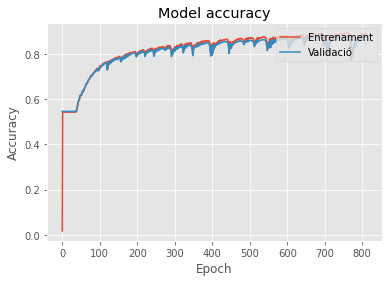

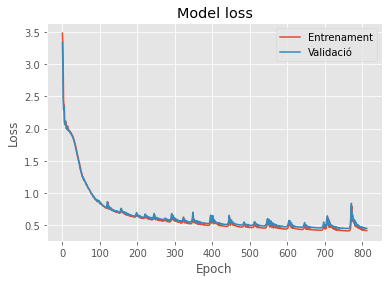

In [41]:
# View two graphs to see how accuracy and error evolve during the training process

# Visualize the evolution of the network accuracy
plt.plot(gcn_history.history['accuracy'])
plt.plot(gcn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Entrenament', 'Validació'], loc='upper right')
plt.show()

# Visualize the evolution of the network error
plt.plot(gcn_history.history['loss'])
plt.plot(gcn_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Entrenament', 'Validació'], loc='upper right')
plt.show()

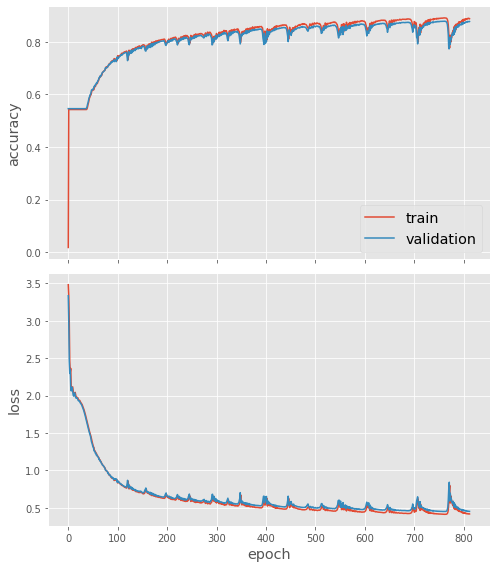

In [42]:
# View two graphs to see how accuracy and error evolve during the training process
utils.plot_history(gcn_history)

In [43]:
# Evaluate model performance on Validation Set
val_metrics = gcn_model.evaluate(val_gen)
print("\nValidatiom Set Metrics:")

for name, value in zip(gcn_model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, value))

1/1 [==============================] - 0s 205ms/step - loss: 0.4492 - accuracy: 0.8784

Validatiom Set Metrics:
	loss: 0.4492
	accuracy: 0.8784


In [44]:
# Save the model
gcn_model.save(os.path.join(models_dir, 'gcn_model_311_features.h5'))

In [45]:
from keras.models import load_model
from stellargraph.layer.gcn import GraphConvolution
from stellargraph.layer.misc import GatherIndices, SqueezedSparseConversion

# Load the model
gcn_model = load_model(os.path.join(models_dir,'gcn_model_311_features.h5'), custom_objects={
    'GraphConvolution': GraphConvolution, 
    'GatherIndices': GatherIndices, 
    'SqueezedSparseConversion': SqueezedSparseConversion
})

## Making predictions with the model

**Validation Set**

In [46]:
# Make predictions on Validation Set
val_gen = generator.flow(val.node_id)
val_predictions = gcn_model.predict(val_gen)

In [47]:
# Convert one-hot-encoding label to Text label
val_node_predictions = target_encoding.inverse_transform(val_predictions.squeeze())

val['node_prediction'] = val_node_predictions

val.tail(10)

,node_id,node_target,node_prediction
id,,,
137445,naturedecouvertes217_137445,OTHER,OTHER
137446,naturedecouvertes217_137446,OTHER,OTHER
137447,naturedecouvertes217_137447,SUPPLIER_VAT,SUPPLIER_VAT
137449,naturedecouvertes217_137449,OTHER,OTHER
137450,naturedecouvertes217_137450,OTHER,OTHER
137451,naturedecouvertes217_137451,OTHER,OTHER
137452,naturedecouvertes217_137452,SUPPLIER_FAX_NUMBER,SUPPLIER_FAX_NUMBER
137453,naturedecouvertes217_137453,OTHER,OTHER
137454,naturedecouvertes217_137454,OTHER,OTHER


In [48]:
# Compute frequency on each one of classes for class attribute 'node_target'
val["node_target"].value_counts()

OTHER                              73444
PRODUCT_DESCRIPTION                11394
SUPPLIER_ADDRESS                    6985
BILLING_ADDRESS                     4623
SHIPPING_ADDRESS                    4524
INVOICE_DATE                        2790
SUPPLIER_VAT                        2779
SUPPLIER_NAME                       2707
PRODUCT_TOTAL_PRICE_WITHOUT_TAX     2470
UNIT_PRICE                          2251
SUPPLIER_CONTACT_NUMBER             2188
SUPPLIER_FAX_NUMBER                 1835
QUANTITY                            1762
SHIPPING_NAME                       1656
BILLING_NAME                        1654
TOTAL_AMOUNT                        1602
TAX_RATE                            1409
TOTAL_TAX                           1254
SNO                                 1203
SUPPLIER_SIRET                      1006
TOTAL_WITHOUT_TAX                    980
INVOICE_NUMBER                       930
ORDER_NUMBER                         700
SUPPLIER_ID                          548
PRODUCT_TOTAL   

In [49]:
# Compute frequency on each one of classes for class attribute 'node_prediction'
val["node_prediction"].value_counts()

OTHER                              74554
PRODUCT_DESCRIPTION                11531
SUPPLIER_ADDRESS                    7147
BILLING_ADDRESS                     4815
SHIPPING_ADDRESS                    4492
INVOICE_DATE                        2966
SUPPLIER_VAT                        2799
PRODUCT_TOTAL_PRICE_WITHOUT_TAX     2551
UNIT_PRICE                          2331
SUPPLIER_NAME                       2109
SUPPLIER_CONTACT_NUMBER             2051
QUANTITY                            1840
SUPPLIER_FAX_NUMBER                 1663
TOTAL_AMOUNT                        1619
SHIPPING_NAME                       1568
BILLING_NAME                        1518
TAX_RATE                            1347
SNO                                 1195
TOTAL_TAX                           1138
TOTAL_WITHOUT_TAX                    911
SUPPLIER_SIRET                       851
INVOICE_NUMBER                       813
ORDER_NUMBER                         547
SUPPLIER_ID                          535
PRODUCT_TOTAL   

In [50]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate some metrics: precision, recall i f1-score by class on Validation Set.
print('\n Mètriques precision, recall i f1-score obtingudes per classe')
print(classification_report(val.node_target, val_node_predictions))


 Mètriques precision, recall i f1-score obtingudes per classe
                                 precision    recall  f1-score   support

                BILLING_ADDRESS       0.80      0.84      0.82      4623
                   BILLING_NAME       0.69      0.63      0.66      1654
                  CLIENT_NUMBER       0.54      0.65      0.59       300
                          IMAGE       0.85      0.34      0.49       200
                   INVOICE_DATE       0.75      0.79      0.77      2790
                 INVOICE_NUMBER       0.71      0.62      0.67       930
                   ORDER_NUMBER       0.77      0.60      0.68       700
                          OTHER       0.93      0.94      0.93     73444
                   PAYMENT_MODE       0.78      0.54      0.64       430
            PRODUCT_DESCRIPTION       0.92      0.93      0.93     11394
                  PRODUCT_TOTAL       0.92      0.88      0.90       543
PRODUCT_TOTAL_PRICE_WITHOUT_TAX       0.88      0.91      0.


Matriu de confusió


Text(114.0, 0.5, 'Real')

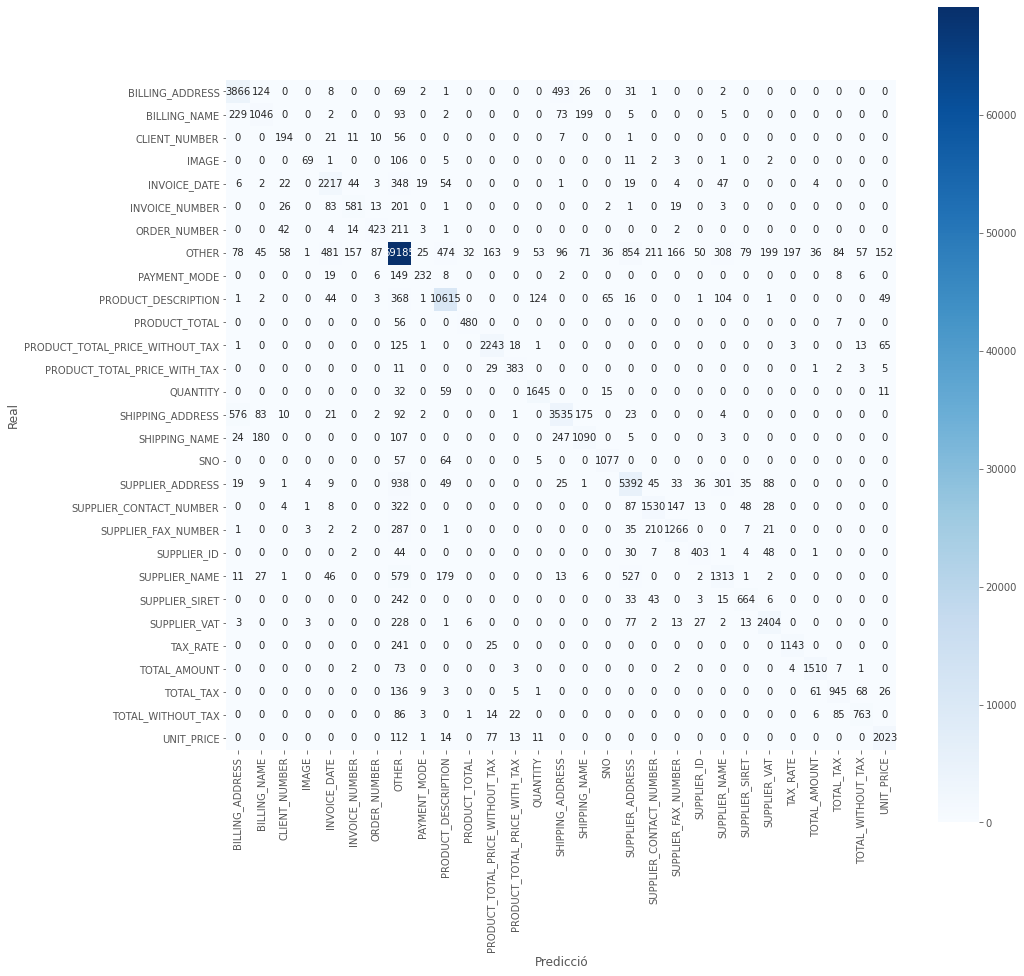

In [51]:
# Visualize confusion matrix
print('\nMatriu de confusió')
matrix = confusion_matrix(val.node_target, val_node_predictions)

targets = target_encoding.classes_

plt.figure(figsize=(15, 15))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
ax.set_xticklabels(targets, rotation = 90, size = 10)
ax.set_yticklabels(targets, rotation = 0, size = 10)
plt.xlabel("Predicció")
plt.ylabel("Real")

**Test Set**

In [52]:
# Evaluate model performance on Test Set
test_gen = generator.flow(test.node_id, test_targets)

test_metrics = gcn_model.evaluate(test_gen)

print("\nTest Set Metrics:")

for name, val in zip(gcn_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 388ms/step - loss: 0.4525 - accuracy: 0.8775

Test Set Metrics:
	loss: 0.4525
	accuracy: 0.8775


In [53]:
test_gen = generator.flow(test.node_id)
test_predictions = gcn_model.predict(test_gen)

# Convert one-hot-encoding label to Text label
test_node_predictions = target_encoding.inverse_transform(test_predictions.squeeze())

test['node_prediction'] = test_node_predictions

test.head(10)

,node_id,node_target,node_prediction
id,,,
62801,darty77_62801,SUPPLIER_NAME,OTHER
62802,darty77_62802,SUPPLIER_NAME,OTHER
62803,darty77_62803,SUPPLIER_NAME,OTHER
62828,darty77_62828,SHIPPING_NAME,SHIPPING_ADDRESS
62829,darty77_62829,SHIPPING_NAME,SHIPPING_ADDRESS
62804,darty77_62804,OTHER,OTHER
62805,darty77_62805,OTHER,OTHER
62830,darty77_62830,SHIPPING_ADDRESS,SHIPPING_ADDRESS
62831,darty77_62831,SHIPPING_ADDRESS,SHIPPING_ADDRESS


In [54]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate some metrics: precision, recall i f1-score by class on Test Set.
print('\n Mètriques precision, recall i f1-score obtingudes per classe')
print(classification_report(test.node_target, test_node_predictions))


 Mètriques precision, recall i f1-score obtingudes per classe
                                 precision    recall  f1-score   support

                BILLING_ADDRESS       0.78      0.83      0.81      2294
                   BILLING_NAME       0.72      0.64      0.68       813
                  CLIENT_NUMBER       0.63      0.58      0.60       150
                          IMAGE       0.87      0.27      0.41       100
                   INVOICE_DATE       0.75      0.79      0.77      1392
                 INVOICE_NUMBER       0.73      0.64      0.69       468
                   ORDER_NUMBER       0.81      0.60      0.69       350
                          OTHER       0.93      0.94      0.93     36887
                   PAYMENT_MODE       0.78      0.50      0.61       215
            PRODUCT_DESCRIPTION       0.92      0.93      0.92      5969
                  PRODUCT_TOTAL       0.95      0.86      0.90       278
PRODUCT_TOTAL_PRICE_WITHOUT_TAX       0.88      0.91      0.


Matriu de confusió


Text(114.0, 0.5, 'Real')

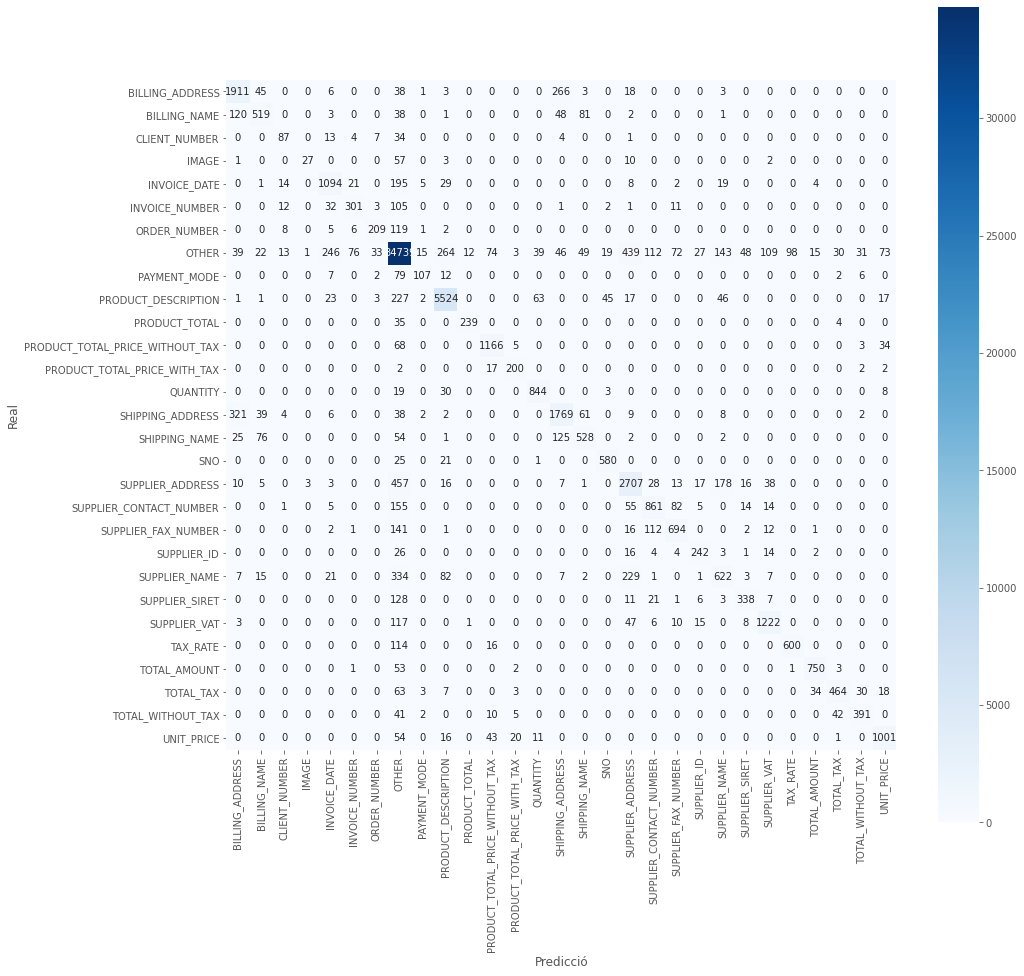

In [55]:
# Visualize confusion matrix
print('\nMatriu de confusió')
matrix = confusion_matrix(test.node_target, test_node_predictions)

targets = target_encoding.classes_

plt.figure(figsize=(15, 15))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
ax.set_xticklabels(targets, rotation = 90, size = 10)
ax.set_yticklabels(targets, rotation = 0, size = 10)
plt.xlabel("Predicció")
plt.ylabel("Real")


Matriu de confusió


Text(114.0, 0.5, 'Real')

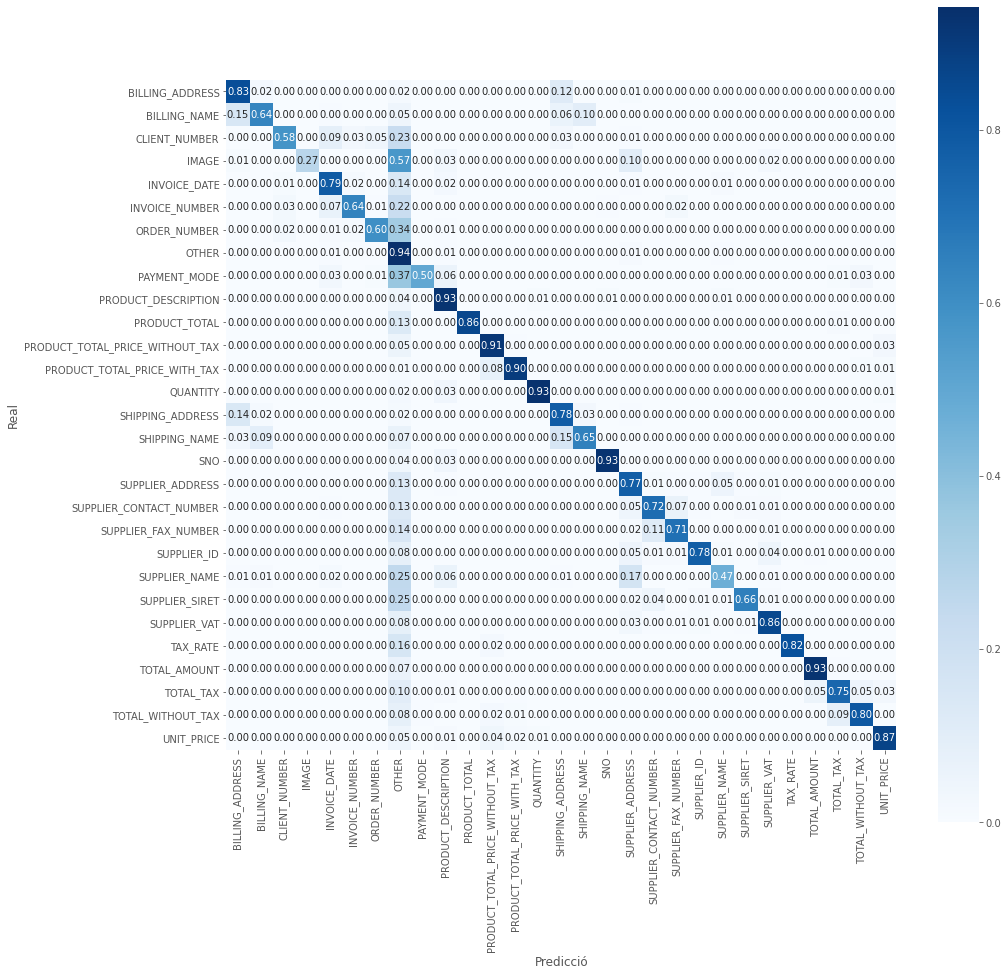

In [56]:
# Visualize normalize confusion matrix
print('\nMatriu de confusió')
matrix = confusion_matrix(test.node_target, test_node_predictions, normalize='true')

targets = target_encoding.classes_

plt.figure(figsize=(15, 15))
ax = sns.heatmap(matrix, annot=True, cmap='Blues', fmt='.2f', square=True)
ax.set_xticklabels(targets, rotation = 90, size = 10)
ax.set_yticklabels(targets, rotation = 0, size = 10)
plt.xlabel("Predicció")
plt.ylabel("Real")